In [2]:
import random
import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow import convert_to_tensor
import tensorflow as tf


from transformers import AutoTokenizer, AutoModel

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Загружаем данные текстов

In [3]:
train = pd.read_csv("./train_dataset_train/train.csv")

print(train.shape)

train.head(3)

(2098, 3)


,id,description,object_img
0,520,Фотография. Г. Пермь. Здание горисполкома. ПО...,799
1,1817,Фотонегатив пленочный. Труппа театра «У моста»...,854
2,188,"Изразец гладкий расписной ""пермский""- карниз А...",1794


In [4]:
test = pd.read_csv("./test_dataset_test/test.csv")

print(test.shape)

test.head(3)

(900, 2)


,id,description
0,486,Фотография. Елизавета Алексеевна Юманова. ПКМ...
1,813,Фотография. Заседание комитета комсомола мотор...
2,2980,"Фотография. День ""Саланга"". ПОКМ-18530/638 фо..."


## Загружаем внешние модели

Модели нужны для векторизации текстов и изображений, чтобы можно было потом с ними работать

1. Для текстов - русскоязычная версия BERT от DeepPavlov 
2. Для изображений - EfficientNetB0

In [5]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

In [6]:
image_model = EfficientNetB0(include_top=True, weights='imagenet')

## Функции предобработки данных

Тексты и изображения превращаем в вектора с помощью моделей выше, вектора нормализуем, чтобы было проще с ними работать, сохраняем результаты.

In [10]:
def text_processing(texts):
    result = []
    for text in tqdm(texts):
        tokenized = tokenizer(text, return_tensors="pt")
        embeddings = bert(**tokenized, output_hidden_states=True).pooler_output
        result.append(embeddings.detach().numpy()[0])
    embeddings = convert_to_tensor(result, dtype='float32')
    embeddings = tf.linalg.normalize(embeddings, axis=1)[0]
    return embeddings

In [11]:
def train_image_processing(images):
    result = []
    for i in tqdm(images):
        img = np.expand_dims(
            image.img_to_array(
                image.load_img(f'./train_dataset_train/train/{i}.png', target_size=(224, 224, 3))
            ), axis=0)
        result.append(image_model(img)[0])
    embeddings = convert_to_tensor(result, dtype='float32')
    embeddings = tf.linalg.normalize(embeddings, axis=1)[0]
    return embeddings

In [12]:
train_texts = text_processing(train['description'].values.tolist())

  0%|          | 0/2098 [00:00<?, ?it/s]

In [13]:
train_images = train_image_processing(train['object_img'].values.tolist())

  0%|          | 0/2098 [00:00<?, ?it/s]

In [14]:
train_texts.shape, train_images.shape

(TensorShape([2098, 768]), TensorShape([2098, 1000]))

## Строим модель 

Смысл модели - мы учимся превращать вектора текстов в вектора изображений, чтобы потом по получившемуся вектору найти подходящее изображение

In [15]:
inputs = tf.keras.Input(shape=(768,))
x = tf.keras.layers.Dense(200, activation=tf.nn.tanh)(inputs)
outputs = tf.keras.layers.Dense(1000, activation=tf.nn.tanh)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

Так как мы срравниваем ветора, логично в качестве метрики близости использовать косинусное расстояние

In [16]:
model.compile(
    optimizer='rmsprop', 
    loss='cosine_similarity', 
    metrics=['cosine_similarity']
)

Обучаем модель

In [17]:
model.fit(train_texts, train_images, epochs=500, verbose=0, shuffle=True, validation_split=0.1)

**Статистика по модели**

In [18]:
stats = []
for i in range(len(train_texts)):
    result = [
        e[0]
        for e in sorted(
                enumerate(*cosine_similarity(model(train_texts[i:i+1]), train_images)), 
                key=lambda x: x[1], reverse=True
            )
        ]
    stats.append((
        i, 
        result[0], 
        train.iloc[i]['id'], 
        train.iloc[i]['object_img'], 
        train.iloc[result[0]]['object_img'], 
        result.index(i)
    ))

In [19]:
stats = pd.DataFrame(stats, columns=['idx','best_idx', 'id','object_img', 'object_img_best', 'true'])

In [20]:
stats['true'].mean(), (stats['true'] == 0).mean(), (stats['true'] < 3).mean(), (stats['true'] < 10).mean()

(157.72592945662535,
 0.04575786463298379,
 0.09866539561487131,
 0.21067683508102955)

В среднем точное изображение находится довольно далеко, скорее всего, поому что попадаются похожие впереди

In [21]:
from sklearn.metrics import r2_score

In [22]:
r2_score(stats['object_img'], stats['object_img_best'])

0.6506604702729499

Да, видно, что результаты по R2 (соседние изображения похожи) неплохие, получается, что изображения "на тему" модель находит.

Посмотрим пример. 1 изображение - истинное, 5 справа - это предложения от модели.

1721 Фотография. Пермская зональная комсомольская школа.  ПОКМ-18530/2288 фотопечать,картон,фотобумага     


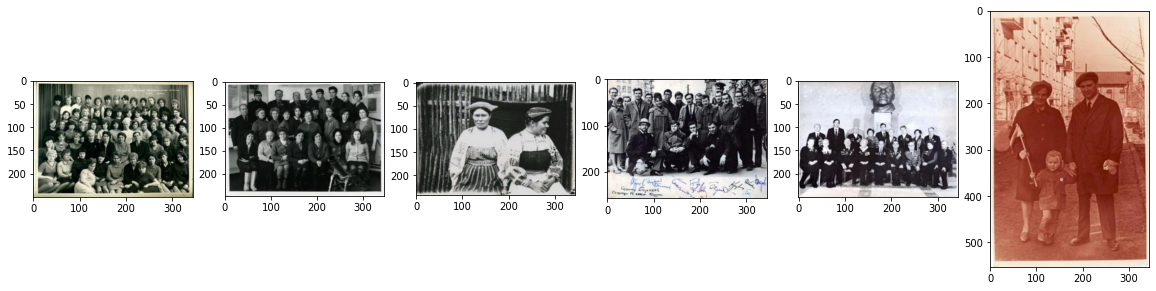

1785 Гербарий. Шиповник игольчатый. Rosa acicularis Lindl.  ПОКМ-7925/32 гербарий,высушено,расправлено,смонтировано на лист а3 формата    Теплоухов Федор Александрович Цветущая ветвь.


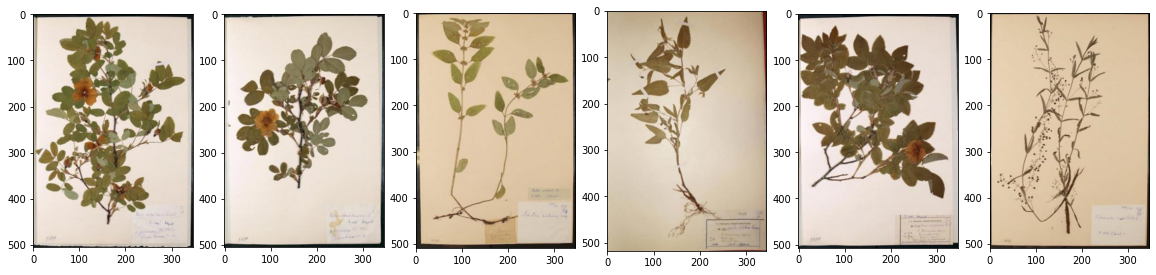

1704 Фотография. В.В. Кузнецов с коллегами на ноябрьской демонстрации.  ПКМ-21546/158 фотопечать,фотобумага     Черно-белое изображение женщины и трех мужчин в теплой одежде возле группы людей (демонстрантов), знамени. Края фотографии оформлены фигурным резаком.


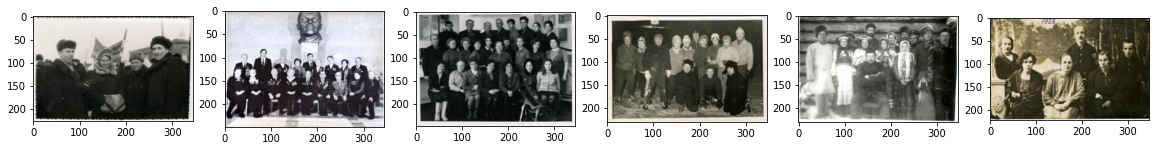

66 Фотография. Пересечение улиц Ленина и К.Маркса.  ПОКМ-19814/1413 фотопечать,фотобумага     Изображен перекресток двух улиц. На переднем плане слева угловой высокий трехэтажный каменный дом с рядами окон и названиями магазинов на первом этаже. Справа к нему примыкают стоящие вдоль улицы невысокие двух- и одноэтажные дома. На заднем плане виднеется строящееся многоэтажное здание. По тротуарам и через перекресток в разных направлениях ходят люди.


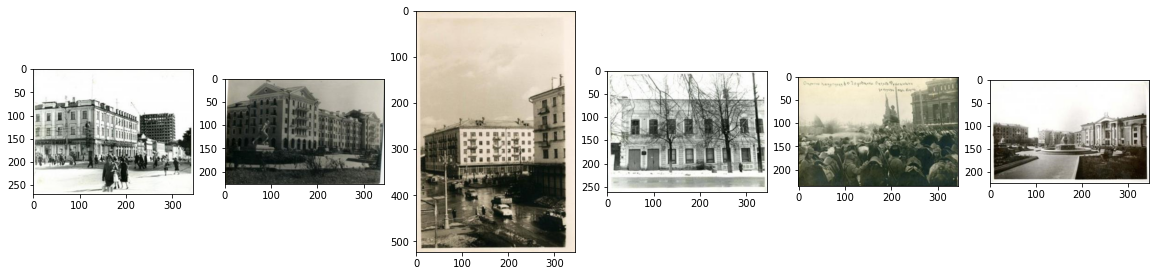

1487 Шашка, драгунская, офицерская, образца 1881 года. ОР-215 ПОКМ-4768 сталь,дерево,латунь,медь,ковка     Клинок слабой кривизны, однолезвийный с широким долом, конец (10 см) обоюдоострый. Крестовина латунная. Один конец загнут к обуху и образует отверстие для темляка, другой переходит в дужку, упирающуюся в набалдашник из красной меди. Черен деревянный с косой насечкой.


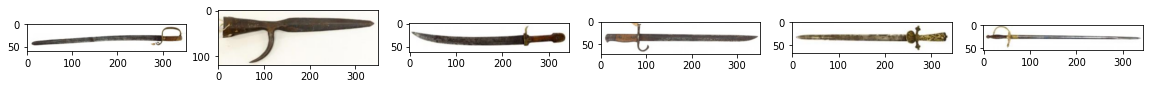

In [23]:
for i in random.choices(train.index, k=5):
    print(i, train.iloc[i]['description'])
    result = sorted(list(enumerate(*cosine_similarity(model(train_texts[i:i+1]), train_images))), key=lambda x: x[1], reverse=True)[:5]
    f, axarr = plt.subplots(1, 6, figsize=(20, 5))
    axarr[0].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[i]["object_img"]}.png'))
    axarr[1].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[result[0][0]]["object_img"]}.png'))
    axarr[2].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[result[1][0]]["object_img"]}.png'))
    axarr[3].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[result[2][0]]["object_img"]}.png'))
    axarr[4].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[result[3][0]]["object_img"]}.png'))
    axarr[5].imshow(mpimg.imread(f'./train_dataset_train/train/{train.iloc[result[4][0]]["object_img"]}.png'))
    plt.show()

Тут не очень удачно выпали фото, группы (ядро, пейзаж, шашка, фото города, гербарий и тд) хорошо выделяются (см. демо)

## Обрабатываем тестовые данные и делаем предсказания

In [24]:
def test_image_processing():
    images = sorted([int(e.split('.')[0]) for e in os.listdir('./test_dataset_test/test/')])
    result = []
    for i in tqdm(images):
        img = np.expand_dims(
            image.img_to_array(
                image.load_img(f'./test_dataset_test/test/{i}.png', target_size=(224, 224, 3))
            ), axis=0)
        result.append(image_model(img)[0])
    embeddings = convert_to_tensor(result, dtype='float32')
    embeddings = tf.linalg.normalize(embeddings, axis=1)[0]
    return embeddings, images

In [25]:
test_images, test_images_idx = test_image_processing()

  0%|          | 0/900 [00:00<?, ?it/s]

In [26]:
test_texts = text_processing(test['description'].values.tolist())

  0%|          | 0/900 [00:00<?, ?it/s]

In [27]:
test_images.shape, test_texts.shape

(TensorShape([900, 1000]), TensorShape([900, 768]))

## Отправленные ответы

Без повторений приходится делать более сложный обход

In [28]:
final = []
for i in tqdm(range(len(test_texts))):
    true_id = test.iloc[i]['id']
    result = [
        (true_id, test_images_idx[e[0]], e[1])
        for e in sorted(
                enumerate(*cosine_similarity(model(test_texts[i:i+1]), test_images)), 
                key=lambda x: x[1], reverse=True
            )
        ]
    final.extend(result)

final = pd.DataFrame(final, columns=['id', 'object_img', 'similarity'])

ids = set(final['id'].values)
object_imgs = set(final['object_img'].values)

final = final.sort_values(by=['similarity', 'object_img', 'id'], ascending=False)

answer = []
for idx, obj, prob in tqdm(final.values):
    if idx in ids and obj in object_imgs:
        answer.append((idx, obj))
        ids.remove(idx)
        object_imgs.remove(obj)

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/810000 [00:00<?, ?it/s]

In [29]:
pd.DataFrame(answer, columns=['id', 'object_img']).astype('int').to_csv(f'submission-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.csv', index=False)

### Тестируем, что получается

248 2175 ПЗС. Накладка с изображением головы медведя  ПКМ-21222/40 белый сплав,литье     Накладка полуовальная из тонкой пластины, украшена тисненым изображением головы медведя между лапами, по контуру - бордюр из пояска с поперечными насечками (Д.- № 122 [7], погр. 77)
[(1995, 0.662464), (1936, 0.6287462), (1968, 0.60681933), (1946, 0.5556639), (1904, 0.5427272)]


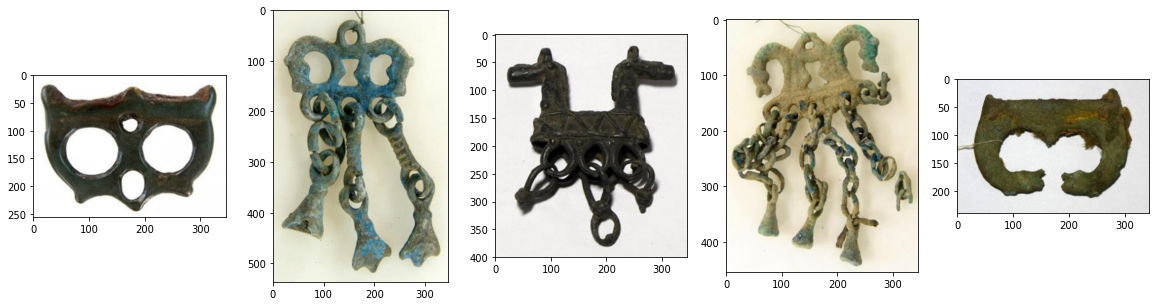

426 1567 Изразец гладкий расписной - лицевой вогнутый "пермский"  ПКМ-21089/39 глина (красная грубокирпичная),эмаль (белая, синяя, лиловая),формовка,роспись     Лицевая пластина по периметру оконтурена двойной полосой синей эмали, и тонкими полосами лиловой эмали.  Румпа отступающая от края лицевой пластины. (ПГУ 1735/36. Р-3, LХ1У - LХУ/7-8 гл. 0,2 - 0,35 м. яма)
[(1735, 0.74685794), (1746, 0.72747725), (1854, 0.7237507), (1780, 0.72124296), (1805, 0.720526)]


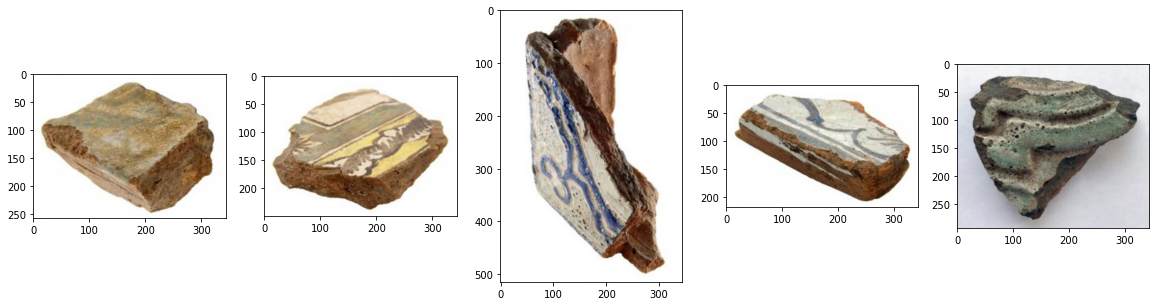

209 2093 Фотонегатив пленочный. Памятник героям-танкистам, возложение венков.  ПОКМ-15007/77 фотосъемка,пленка    Загуляев Евгений Николаевич (Фотограф) Изображение памятника в виде танка, рядом с которым лежит венок и стоят двое мужчин в форме. На заднем плане к барильефу подходят несколько мужчин с венком.
[(307, 0.5766946), (679, 0.54388857), (1613, 0.5324921), (1568, 0.5270693), (1492, 0.52331626)]


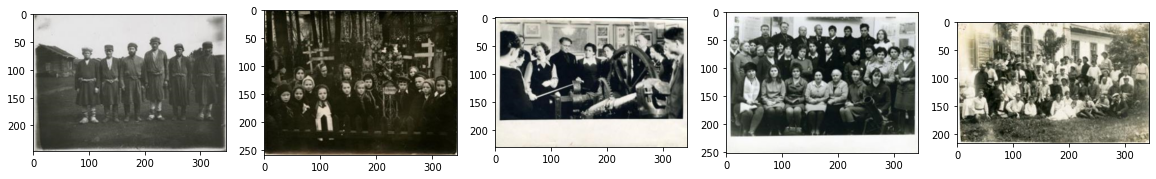

266 1981 Фотография. Сбор подписей против строительства АЭС на Урале. ПГУ.  ПОКМ-18530/1133 фотопечать,фотобумага     Снимок сделан сзади, слегка сверху. Изображены в в полный рост, в верхней одежде, две женщины, склонившиеся над небольшими столами и пишущие на листах бумаги. За столами сидят на стульях, спиной к фотографу, девушка и юноша. На заднем плане видны люди. Фотография аннотирована и ретуширована.
[(307, 0.65361786), (1613, 0.6480463), (1568, 0.6304428), (341, 0.58405316), (934, 0.5805935)]


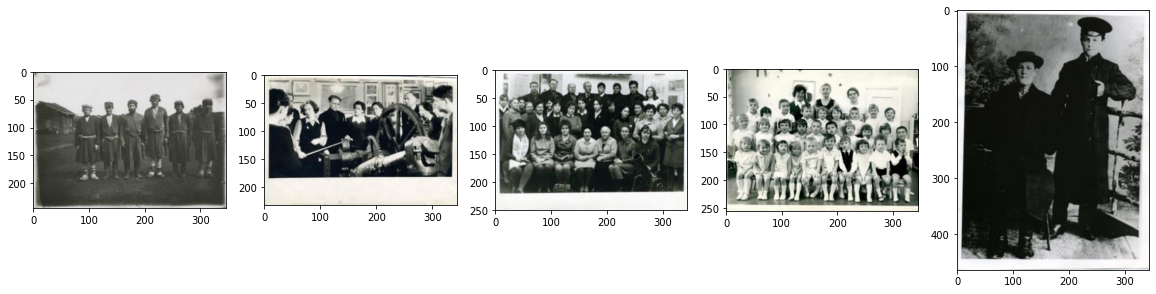

362 2418 Стрела, охотничья, башкирская. ОР-279 ПОКМ-5393 дерево,кустарное производство     Древко гладко обточенное, круглое в сечении, наконечник яйцеобразной формы, черешковый; на конце древка - паз для накладывания на тетиву.
[(2357, 0.59005624), (2383, 0.54402846), (2184, 0.5424466), (2232, 0.53998315), (2423, 0.5369368)]


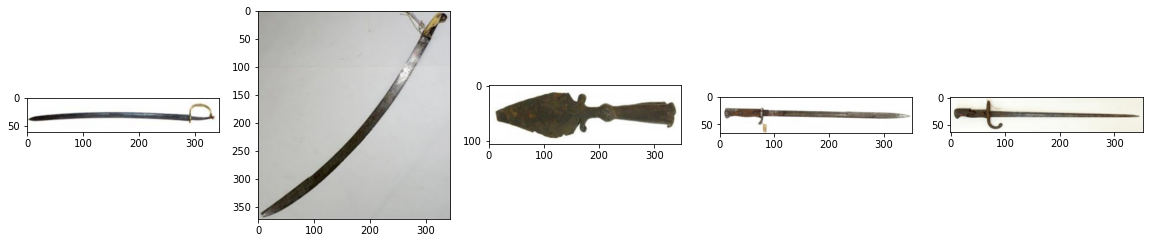

In [40]:
for i in random.choices(test.index, k=5):
    result = sorted(list(zip(test_images_idx, *cosine_similarity(model(test_texts[i:i+1]), test_images))), key=lambda x: x[1], reverse=True)[:5]
    print(i, test.iloc[i]['id'], test.iloc[i]['description'])
    print(result)
    f, axarr = plt.subplots(1, 5, figsize=(20, 5))
    axarr[0].imshow(mpimg.imread(f'./test_dataset_test/test/{result[0][0]}.png'))
    axarr[1].imshow(mpimg.imread(f'./test_dataset_test/test/{result[1][0]}.png'))
    axarr[2].imshow(mpimg.imread(f'./test_dataset_test/test/{result[2][0]}.png'))
    axarr[3].imshow(mpimg.imread(f'./test_dataset_test/test/{result[3][0]}.png'))
    axarr[4].imshow(mpimg.imread(f'./test_dataset_test/test/{result[4][0]}.png'))
    plt.show()

### Сохраняем модель

In [31]:
model.save('model.keras')

## Система для поиска

Собираем вектора в систему, которая позволяет быстро по ним искать ближашие вектора и выдавать ID изображения.

**Тестовая выборка**

In [32]:
from annoy import AnnoyIndex

In [33]:
t = AnnoyIndex(1000, 'euclidean')

In [34]:
len(test_images_idx), len(test_images)

(900, 900)

In [35]:
for i, v in zip(test_images_idx, test_images):
    t.add_item(i, v.numpy())

In [36]:
t.build(10)
t.save('test.ann')

True

**Тренировочная выборка**

In [37]:
t = AnnoyIndex(1000, 'euclidean')

for i, v in zip(train['object_img'].values, train_images):
    t.add_item(i, v.numpy())
    
t.build(20)
t.save('train.ann')

True